In [1]:
import os
import importlib

import cfGPR
import vonkarmanFT as vk
import plotGPR

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import scipy.optimize as opt
from scipy.spatial.ckdtree import cKDTree

In [2]:
def getGrid(X1, X2):
    u1, u2 = X1[:, 0], X2[:, 0]
    v1, v2 = X1[:, 1], X2[:, 1]
    uu1, uu2 = np.meshgrid(u1, u2)
    vv1, vv2 = np.meshgrid(v1, v2)
    
    return uu1 - uu2, vv1 - vv2

In [3]:
GP = cfGPR.CurlFreeGPR()
GP.load_fits("folio2")
GP.extract_data(465)
GP.sigma_clip()
GP.split_data(train_size=0.50)

x = GP.Xtest[:, 0]*u.deg
y = GP.Xtest[:, 1]*u.deg
dx = GP.Ytest[:, 0]*u.mas
dy = GP.Ytest[:, 1]*u.mas
err = GP.Etest[:, 0]*u.mas

In [65]:
# Garys xiplus method but to larger separations
params = np.array([
    176.363144,
    2.872473,
    0.000072,
    0.018104,
    0.037296
])

# # Garys xiplus method
# params = np.array([
#     371.581294,
#     -0.019908,
#     0.087349,
#     0.054215,
#     0.251832
# ])


ttt = vk.TurbulentLayer(
    variance=params[0],
    outerScale=params[1],
    diameter=params[2],
    wind=(params[3], params[4]))

In [66]:
du, dv = getGrid(GP.Xtrain, GP.Xtrain)
Cuv = ttt.getCuv(du, dv)
Ku = Cuv[:,:,0,0]
Kv = Cuv[:,:,1,1]

du, dv = getGrid(GP.Xtest, GP.Xtrain)
Cuv = ttt.getCuv(du, dv)
Ks_u = Cuv[:,:,0,0]
Ks_v = Cuv[:,:,1,1]

Wu = np.diag(GP.Etrain[:, 0]**2)
Wv = np.diag(GP.Etrain[:, 1]**2)

Lu = np.linalg.cholesky(Ku + Wu)
Lv = np.linalg.cholesky(Kv + Wv)

alpha_u = np.linalg.solve(Lu.T, np.linalg.solve(Lu, GP.Ytrain[:, 0]))
alpha_v = np.linalg.solve(Lv.T, np.linalg.solve(Lv, GP.Ytrain[:, 1]))

fbar_s_u = np.dot(Ks_u.T, alpha_u)
fbar_s_v = np.dot(Ks_v.T, alpha_v)

GP.fbar_s = np.vstack((fbar_s_u, fbar_s_v)).T

In [67]:
# Garys xiplus method but to larger separations
res = GP.Ytest - GP.fbar_s
rMax = (0.2*u.deg).to(u.deg).value
rMin = (5*u.mas).to(u.deg).value
kdt = cKDTree(GP.Xtest)
prs_set = kdt.query_pairs(rMax, output_type='set')
prs_set -= kdt.query_pairs(rMin, output_type='set')
prs = np.array(list(prs_set))
xiplus = np.mean(np.sum(res[prs[:, 0]] * res[prs[:, 1]], axis=1))
print(xiplus)

# Garys xiplus method
res = GP.Ytest - GP.fbar_s
rMax = (0.02*u.deg).to(u.deg).value
rMin = (5*u.mas).to(u.deg).value
kdt = cKDTree(GP.Xtest)
prs_set = kdt.query_pairs(rMax, output_type='set')
prs_set -= kdt.query_pairs(rMin, output_type='set')
prs = np.array(list(prs_set))
xiplus = np.mean(np.sum(res[prs[:, 0]] * res[prs[:, 1]], axis=1))
print(xiplus)

# My xiplus method
res = GP.Ytest - GP.fbar_s
rMax = (0.2*u.deg).to(u.deg).value
rMin = (5*u.mas).to(u.deg).value
r = np.linspace(rMin, rMax, 100)
kdt = cKDTree(GP.Xtest)
xiplus = np.zeros(r.shape)
for i, radius in enumerate(r):
    prsmax = kdt.query_pairs(r[i], output_type='ndarray')
    xiplus[i] = np.nanmean(res[prsmax][:, 0, :] * res[prsmax][:, 1, :])
xiplus = np.nanmean(xiplus)
print(xiplus)

1.7255427769745242
34.409745133027165


/home/fortino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


5.255441707829274


In [68]:
x = GP.Xtest[:, 0]*u.deg
y = GP.Xtest[:, 1]*u.deg
dx = GP.Ytest[:, 0]*u.mas
dy = GP.Ytest[:, 1]*u.mas
err = GP.Etest[:, 0]*u.mas

x2 = GP.Xtest[:, 0]*u.deg
y2 = GP.Xtest[:, 1]*u.deg
dx2 = GP.Ytest[:, 0]*u.mas - GP.fbar_s[:, 0]*u.mas
dy2 = GP.Ytest[:, 1]*u.mas - GP.fbar_s[:, 1]*u.mas
err2 = GP.Etest[:, 0]*u.mas

/home/fortino/DESworkspace/plotGPR.py:904: RuntimeWarning: invalid value encountered in true_divide
  np.nan)
/home/fortino/DESworkspace/plotGPR.py:908: RuntimeWarning: invalid value encountered in true_divide
  np.nan)
/home/fortino/DESworkspace/plotGPR.py:912: RuntimeWarning: divide by zero encountered in reciprocal
  x = (((x % binGridSize_x) + 0.5) * cellSize) + min_x
/home/fortino/DESworkspace/plotGPR.py:923: RuntimeWarning: invalid value encountered in less
  
/home/fortino/DESworkspace/plotGPR.py:930: RuntimeWarning: invalid value encountered in greater
  
/home/fortino/DESworkspace/plotGPR.py:931: RuntimeWarning: invalid value encountered in greater
  def calcDivCurl(x, y, dx, dy):
/home/fortino/DESworkspace/plotGPR.py:932: RuntimeWarning: invalid value encountered in greater
  """


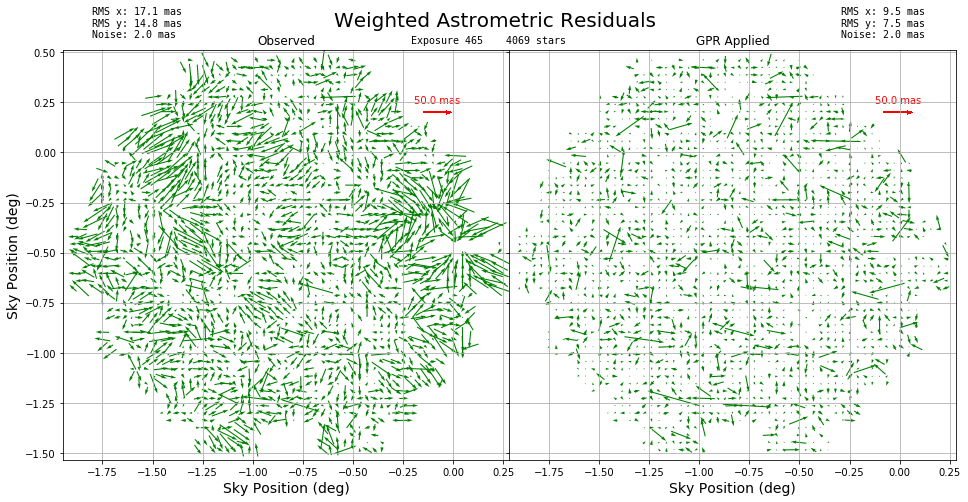

In [176]:
plotGPR.AstrometricResiduals(
    x, y, dx, dy, err,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2, err2=err2,
    title1="Observed", title2="GPR Applied",
    minPoints=100,
    pixelsPerBin=500,
    maxErr=50*u.mas,
    scale=350*u.mas,
    arrowScale=50*u.mas,
    savePath=".", saveExt="",
    plotShow=True,
    exposure=465
    )

/home/fortino/DESworkspace/plotGPR.py:904: RuntimeWarning: invalid value encountered in true_divide
  np.nan)
/home/fortino/DESworkspace/plotGPR.py:908: RuntimeWarning: invalid value encountered in true_divide
  np.nan)
/home/fortino/DESworkspace/plotGPR.py:912: RuntimeWarning: divide by zero encountered in reciprocal
  x = (((x % binGridSize_x) + 0.5) * cellSize) + min_x
/home/fortino/DESworkspace/plotGPR.py:923: RuntimeWarning: invalid value encountered in less
  
/home/fortino/DESworkspace/plotGPR.py:930: RuntimeWarning: invalid value encountered in greater
  
/home/fortino/DESworkspace/plotGPR.py:931: RuntimeWarning: invalid value encountered in greater
  def calcDivCurl(x, y, dx, dy):
/home/fortino/DESworkspace/plotGPR.py:932: RuntimeWarning: invalid value encountered in greater
  """


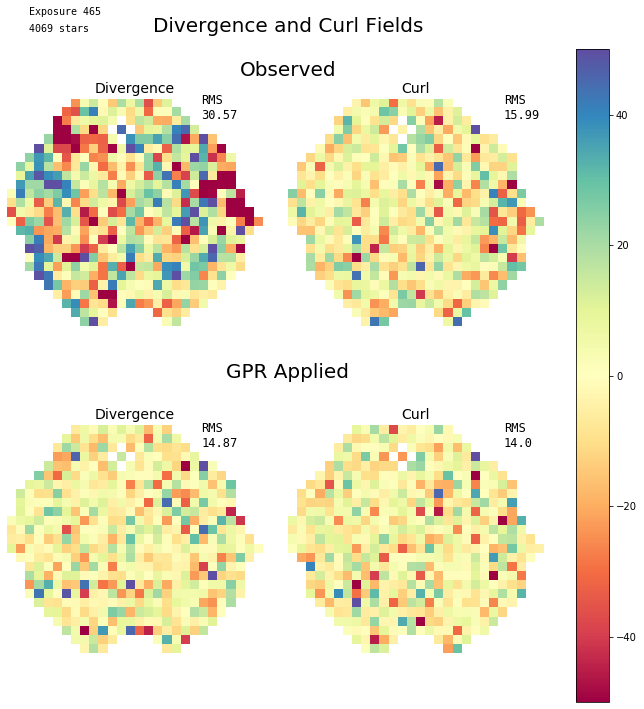

In [177]:
plotGPR.DivCurl(
    x, y, dx, dy, err,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2, err2=err2,
    title1="Observed", title2="GPR Applied",
    minPoints=100,
    pixelsPerBin=1000,
    maxErr=50*u.mas,
    scale=50,
    savePath=".", saveExt=None,
    plotShow=True,
    exposure=465
)

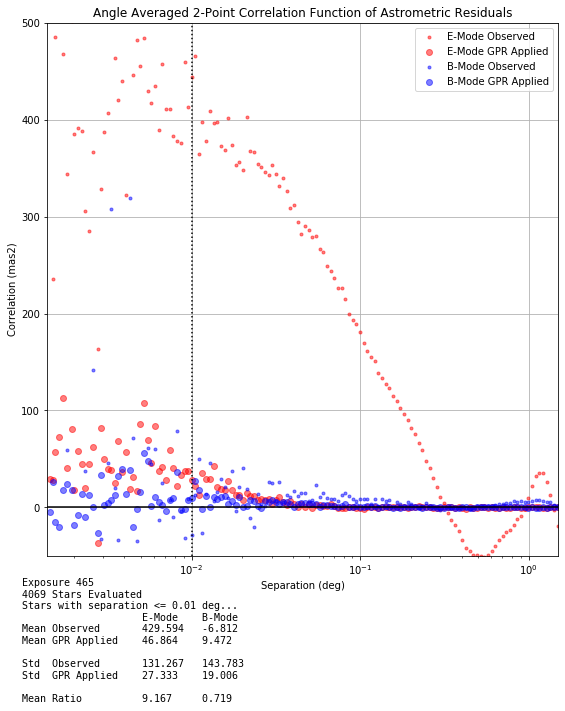

In [261]:
importlib.reload(plotGPR)
plotGPR.Correlation(
    x, y, dx, dy,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2,
    title1="Observed", title2="GPR Applied",
    xiE_ON=True, xiB_ON=True,
#     xiplus_ON=True, ximinus_ON=True,
#     xicross_ON=True, xiz2_ON=True,
    rmin=5*u.arcsec, rmax=1.5*u.deg, dlogr=0.05,
    ylim=(-50, 500),
    sep=1e-2*u.deg, avgLine=True,
    savePath="., saveExt=None,
    plotShow=True,
    exposure=465,
    showInfo=True
    )

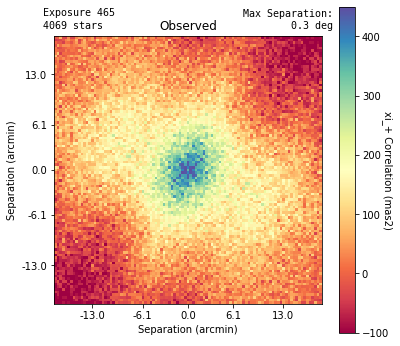

In [269]:
importlib.reload(plotGPR)
plotGPR.Correlation2D(
    x, y, dx, dy,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2,
    title1="Observed", title2="GPR Applied", title3="GPR Interpolation",
    rmax=0.3*u.deg, nBins=100,
    vmin=-100*u.mas**2, vmax=450*u.mas**2,
    savePath=None, saveExt=None,
    plotShow=True,
    exposure=465
    )